## Questions

Are students asking conceptual or appllied questions?
Which topics are more prevalent? Where is the most confusion?
    - Topic Modeling
    - Run the same topic model over different intervals of time
What do in-person interactions not already tell us? 
What are areas that need attention in student understanding? 
    - Concrete evidence of topics where students are struggling
Probably don't look at response time
What are people afraid of asking about? (Anonymous posts from students)
Data:
    - Timestamp
    - Userid (student or instructor, throw out announcements)
    - Question or answer? 
    - Votes (good question)
    - Question Text

    
diff values of config?
Check status = active
transform to get length of upvote_ids

Question or Answer? 
Num votes/good question
where does anon equal yes

In [68]:
import glob
import pickle
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import random
from typing import List, Tuple

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 

In [69]:
dfs = glob.glob('data/dataframes/*.p')
dfs

['data/dataframes/kimia@live.unc.edu_posts_iqv0bsb3p2i3ch.p_dataframe_iqv0bsb3p2i3ch.p',
 'data/dataframes/lexokan@live.unc.edu_posts_j5wwaj87hvu6af.p_dataframe_j5wwaj87hvu6af.p',
 'data/dataframes/dupreezd@live.unc.edu_posts_jz8ejj1lawb5st.p_dataframe_jz8ejj1lawb5st.p',
 'data/dataframes/dupreezd@live.unc.edu_posts_jqnyuvgzug4p3.p_dataframe_jqnyuvgzug4p3.p',
 'data/dataframes/dupreezd@live.unc.edu_posts_jkws0l0gvcr7it.p_dataframe_jkws0l0gvcr7it.p']

In [70]:
def print_topics(model, vectorizer, top_n: int=10)-> List: 
    """Print the top n words found by each topic model.
    
    Args:
        model: Sklearn LatentDirichletAllocation model
        vectorizer: sklearn CountVectorizer
        top_n (int): Number of words you wish to return 
        
    Source: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
    
    """
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
    return [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n-1:-1]]
        
def lda_operation(data_samples, num_features: int=400, num_topics: int=6)-> Tuple: 
    """Performs Latent Dirichlet Allocation on a list of our text samles 
    
    Args:
        data_samples List[str]: List of strings representing the text of each Piazza post
        num_features (int): Max number of features to be considered by term frequency
        num_topics (int): Number of topics 
    
    Returns:
        tuple: Trained LDA Model and the embedded text in the CountVectorizer
        
    """
    
    tf_vectorizer = CountVectorizer(max_df=.85, min_df=.05, max_features=num_features, stop_words='english', token_pattern=u'(?ui)\\b\\w\w*[a-z]+\\w*\\b')
    
    tf_data_samples = tf_vectorizer.fit_transform(data_samples) 
    tf_feature_names = tf_vectorizer.get_feature_names()

    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=100, learning_method='online', learning_offset=10.,random_state=1).fit(tf_data_samples)
    lda.score(tf_data_samples)

    return lda, tf_vectorizer

def save_topics(model, vectorizer, top_n: int=10)-> List:
    """ Save the top n topics from our trained model
    
    Args:
        model: Sklearn LatentDirichletAllocation model
        vectorizer: sklearn CountVectorizer
        top_n (int): Number of topics
    
    Returns:
        list: A list of the top_n words for each topic 
        
    """
    words_per_topic = []
    for idx, topic in enumerate(model.components_):
        words = [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n-1:-1]]
        words_per_topic.append(words)
    return words_per_topic

In [32]:
# Perform LDA on each of the COMP 401 classes
output = []
for i in range(len(dfs)):
    current_df = pd.read_pickle(dfs[i])
    data_list = current_df["text"].tolist()
    output.append(lda_operation(data_list))

In [81]:
# Save all of the words found by the topic model for each class
all_topic_words = []
for lda_output in output:
    print_topics(*lda_output)
    all_topic_words.append(save_topics(*lda_output))

Topic 0:
[('object', 473.245826992338), ('method', 473.06988484976887), ('public', 433.8483760124484), ('avatar', 78.17749343190209), ('java', 67.36342224356085), ('string', 66.7609407612646), ('class', 55.61240920126569), ('bridgescene', 33.97343062801197), ('command', 24.778752607343893), ('say', 19.168774769040773)]
Topic 1:
[('assignment', 116.36858741999418), ('just', 81.97489587814879), ('make', 70.77112726254455), ('credit', 67.60467982273158), ('extra', 63.10383472932928), ('property', 62.78977386938931), ('sure', 60.82801136661284), ('class', 55.26405864488635), ('checks', 50.37584092704761), ('way', 49.36150348276771)]
Topic 2:
[('class', 443.9362008266993), ('classes', 214.43269222771207), ('java', 189.0131904385507), ('test', 10.569191232160623), ('method', 5.8806429289638995), ('run', 4.062676352932096), ('checks', 1.6993494406814977), ('local', 1.214139489741465), ('sure', 0.9708629715729375), ('file', 0.9310635750805801)]
Topic 3:
[('java', 771.9682095591827), ('run', 53

In [84]:
all_text = [''.join(pd.read_pickle(df)["text"].tolist()) for df in dfs]
all_text = [re.sub(r'(?ui)\\b\\w\w*[a-z]+\\w*\\b', '', text) for text in all_text]

[" Class,      Please check that the scores we have for your final and other gradebook items are correct.      Grades have been assigned based on these scores., which you can see on Sakai.      Please let us know of any mistakes in the scores we have for you before we commit the grades tomorrow. Do this only if \xa0you think it will bump your grade to the next one.      We have processed all of the emails for borderline students.      Here are the cutoffs,, ignore the A&#43; row. These are based on our feeling that even if you missed the last few assignments but showed knowledge of the material through exams, you are prepared to be a comp sci major.      GradeMinimum %   A\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   93   A-\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   86   B&#43;\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   76.81   B\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   66   B-\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   59.9   C&#43;\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   52   C\xa0\xa0\xa0

In [87]:
all_text[0]

" Class,      Please check that the scores we have for your final and other gradebook items are correct.      Grades have been assigned based on these scores., which you can see on Sakai.      Please let us know of any mistakes in the scores we have for you before we commit the grades tomorrow. Do this only if \xa0you think it will bump your grade to the next one.      We have processed all of the emails for borderline students.      Here are the cutoffs,, ignore the A&#43; row. These are based on our feeling that even if you missed the last few assignments but showed knowledge of the material through exams, you are prepared to be a comp sci major.      GradeMinimum %   A\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   93   A-\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   86   B&#43;\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   76.81   B\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   66   B-\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   59.9   C&#43;\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0   52   C\xa0\xa0\xa0\

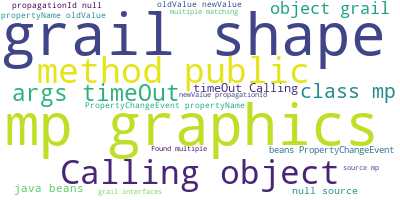

In [88]:
# TODO: Word cloud subplots

wordcloud = WordCloud(background_color="white", max_words=20, contour_width=3, contour_color='steelblue')
wordcloud.generate(all_text[0])
wordcloud.to_image()

In [8]:
# TODO: Distribution of document word counts 
# t-SNE

In [ ]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/